In [ ]:
import os
import torch 
import torch.nn as nn 
from torchvision import datasets 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.hub import load_state_dict_from_url
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
from google.colab import files


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = 512
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
CONTENT_LAYERS = ['conv4_2']
STYLE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

In [ ]:
!wget -O 'style.jpg' https://cdn.pixabay.com/photo/2015/12/15/05/43/starry-night-1093721_1280.jpg
!wget -O 'content.jpg' https://i.ytimg.com/vi/iwMqsKDTdQ0/maxresdefault.jpg

--2022-07-29 18:01:25--  https://cdn.pixabay.com/photo/2015/12/15/05/43/starry-night-1093721_1280.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 172.64.150.12, 104.18.37.244, 2606:4700:4400::6812:25f4, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|172.64.150.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565860 (553K) [image/jpeg]
Saving to: ‘style.jpg’

style.jpg           100%[===================>] 552.60K  --.-KB/s    in 0.04s   

2022-07-29 18:01:25 (15.1 MB/s) - ‘style.jpg’ saved [565860/565860]

--2022-07-29 18:01:25--  https://i.ytimg.com/vi/iwMqsKDTdQ0/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 74.125.142.119, 74.125.195.119, 74.125.20.119, ...
Connecting to i.ytimg.com (i.ytimg.com)|74.125.142.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74287 (73K) [image/jpeg]
Saving to: ‘content.jpg’

content.jpg         100%[===================>]  72.55K  --.-KB/s    in 0.001s  

2022-07-29 18:01:25 (97.

In [ ]:
def load_image(img, device = DEVICE): 
  transform = transforms.Compose([
      transforms.Resize(IMAGE_SIZE), 
      transforms.CenterCrop(IMAGE_SIZE), 
      transforms.ToTensor(), 
      transforms.Normalize(MEAN, STD) 
  ])
  image = transform(img).unsqueeze(0).to(device) 
  return image

with Image.open('style.jpg') as img:
  style_image = load_image(img)

with Image.open('content.jpg') as img:
  content_image = load_image(img)

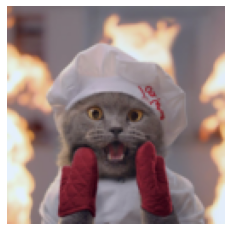

In [ ]:
def plot_image(real_image, show=True):
    img = real_image.data.cpu().numpy()
    plt.axis('off')
    img = img.squeeze()
    img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
    #plt.figure(figsize = (5,5))
    plt.imshow(img)
    plt.show()

plot_image(content_image)

In [ ]:
class VGG19(nn.Module):
  def __init__(self):
    super(VGG19, self).__init__()

    self.conv1_1 = nn.Conv2d(3, 64, kernel_size = 3, padding = 1)
    self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
    self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
    self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
    self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
    self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1) 
    self.conv3_4 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
    self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.conv4_1 = nn.Conv2d(256, 512, kernel_size = 3, padding = 1)
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
    self.conv4_3 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
    self.conv4_4 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
    self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.conv5_1 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
    self.conv5_2 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
    self.conv5_3 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
    self.conv5_4 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
    self.pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2)

  def forward(self, x, layers):
    relu = nn.ReLU(inplace=True)
    output = {}
    output['conv1_1'] = relu(self.conv1_1(x))
    output['conv1_2'] = relu(self.conv1_2(output['conv1_1']))
    output['pool1'] = self.pool1(output['conv1_2'])

    output['conv2_1'] = relu(self.conv2_1(output['pool1']))
    output['conv2_2'] = relu(self.conv2_2(output['conv2_1']))
    output['pool2'] = self.pool2(output['conv2_2'])

    output['conv3_1'] = relu(self.conv3_1(output['pool2']))
    output['conv3_2'] = relu(self.conv3_2(output['conv3_1']))
    output['conv3_3'] = relu(self.conv3_3(output['conv3_2']))
    output['conv3_4'] = relu(self.conv3_4(output['conv3_3']))
    output['pool3'] = self.pool3(output['conv3_4'])

    output['conv4_1'] = relu(self.conv4_1(output['pool3']))
    output['conv4_2'] = relu(self.conv4_2(output['conv4_1']))
    output['conv4_3'] = relu(self.conv4_3(output['conv4_2']))
    output['conv4_4'] = relu(self.conv4_4(output['conv4_3']))
    output['pool4'] = self.pool4(output['conv4_4'])

    output['conv5_1'] = relu(self.conv5_1(output['pool4']))
    output['conv5_2'] = relu(self.conv5_2(output['conv5_1']))
    output['conv5_3'] = relu(self.conv5_3(output['conv5_2']))
    output['conv5_4'] = relu(self.conv5_4(output['conv5_3']))
    output['pool5'] = self.pool5(output['conv5_4'])

    return [output[layer] for layer in layers]

In [ ]:
vgg19 = VGG19().to(DEVICE)

state = vgg19.state_dict()
pretrained_vgg19 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
new_state_values = list(pretrained_vgg19.state_dict().values())

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for i, key in enumerate(state):
  state[key] = new_state_values[i]

vgg19.load_state_dict(state)

<All keys matched successfully>

In [ ]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target

  def forward(self, x):
    loss = 0
    for i, item in enumerate(x):
      loss += nn.MSELoss()(self.target[i], item) 
    return loss

class StyleLoss(nn.Module): 
  def __init__(self, target): 
    super(StyleLoss, self).__init__() 
    self.target = target

  #takes input and returns gram matrix
  def gramMatrix(self, x):
    n, c, h, w = x.size()
    x_reshape = x.view(n * c, h * w)
    return x_reshape @ x_reshape.T / (n * c * h * w)

  def forward(self, x):
    loss = 0
    for i, item in enumerate(x):
      target_gram = self.gramMatrix(self.target[i])
      x_gram = self.gramMatrix(item)
      loss += F.mse_loss(x_gram, target_gram)
    return loss

In [ ]:
def train(vgg19, input_img, content_target, style_target, content_loss, style_loss, steps = 100, style_weight=1000000, content_weight=1): 
  #optimizer 
  optimizer = optim.LBFGS([input_img])

  input_img.requires_grad_(True)
  vgg19.requires_grad_(False)
  content_loss.requires_grad_(False)
  style_loss.requires_grad_(False)

  run = [0]
  while run[0] <= steps:
    def closure():
      optimizer.zero_grad()

      input_content_loss = vgg19(input_img, CONTENT_LAYERS)
      input_style_loss = vgg19(input_img, STYLE_LAYERS)

      content_loss = ContentLoss(content_target)
      style_loss = StyleLoss(style_target)

      c_loss = content_weight * content_loss(input_content_loss)
      s_loss = style_weight * style_loss(input_style_loss)
      total_loss = c_loss + s_loss

      total_loss.backward()

      run[0] += 1
      if run[0] % 10 == 0:
          print("run {}:".format(run))
          print('Style Loss : {:4f} Content Loss: {:4f}'.format(
              s_loss.item(), c_loss.item()))
          print()
      
      return total_loss
    optimizer.step(closure)

  return input_img


In [ ]:
input_img = content_image.clone().detach()
#get the target layers for content, style
content_target = vgg19(content_image, CONTENT_LAYERS)
style_target = vgg19(style_image, STYLE_LAYERS)
  
#initialize the loss functions
content_loss = ContentLoss(content_target)
style_loss = StyleLoss(style_target)

image = train(vgg19, input_img, content_target, style_target, content_loss, style_loss)

run [10]:
Style Loss : 224.083267 Content Loss: 16.695387

run [20]:
Style Loss : 87.762657 Content Loss: 16.221304

run [30]:
Style Loss : 58.190144 Content Loss: 16.551031

run [40]:
Style Loss : 42.452930 Content Loss: 16.549721

run [50]:
Style Loss : 30.043800 Content Loss: 16.429878

run [60]:
Style Loss : 22.303583 Content Loss: 16.370043

run [70]:
Style Loss : 17.074677 Content Loss: 16.205582

run [80]:
Style Loss : 14.628137 Content Loss: 15.932970

run [90]:
Style Loss : 13.368774 Content Loss: 15.728459

run [100]:
Style Loss : 12.433567 Content Loss: 15.639766

run [110]:
Style Loss : 11.849270 Content Loss: 15.498672

run [120]:
Style Loss : 11.334352 Content Loss: 15.408882



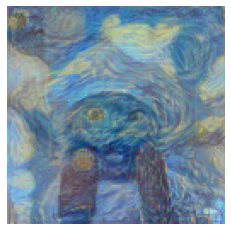

In [ ]:
plot_image(image)

In [ ]:
def post(tensor, mean=MEAN, std=STD):
    mean, std = torch.tensor(mean).view(3, 1, 1), torch.tensor(std).view(3, 1, 1)
    tensor = transforms.Lambda(lambda x: x * std + mean)(tensor.cpu().clone().squeeze(0))
    return transforms.ToPILImage()(tensor.clamp_(0, 1))

output = post(image)
output.save('output.png')
files.download('output.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>